# Nedap Dev Day 2019 - Retail RFID Label Reading

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Description" data-toc-modified-id="Problem-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Description</a></span></li><li><span><a href="#Machine-Learning-Pipeline" data-toc-modified-id="Machine-Learning-Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Machine Learning Pipeline</a></span></li><li><span><a href="#Notebook-Setup" data-toc-modified-id="Notebook-Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Notebook Setup</a></span><ul class="toc-item"><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Utility Functions</a></span></li></ul></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Load-Clean-EPC-Codes" data-toc-modified-id="Load-Clean-EPC-Codes-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load Clean EPC Codes</a></span></li><li><span><a href="#Load-All-Samples" data-toc-modified-id="Load-All-Samples-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Load All Samples</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Number-of-Readings-per-Location" data-toc-modified-id="Number-of-Readings-per-Location-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Number of Readings per Location</a></span></li><li><span><a href="#Number-of-Unique-EPC-Codes-per-Location" data-toc-modified-id="Number-of-Unique-EPC-Codes-per-Location-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Number of Unique EPC Codes per Location</a></span></li><li><span><a href="#Distribution-of-Inside-vs.-Outside-Readings-Across-Labelsets" data-toc-modified-id="Distribution-of-Inside-vs.-Outside-Readings-Across-Labelsets-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Distribution of Inside vs. Outside Readings Across Labelsets</a></span></li><li><span><a href="#Distribution-of-Inside-vs.-Outside-Readings-Across-Locations" data-toc-modified-id="Distribution-of-Inside-vs.-Outside-Readings-Across-Locations-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Distribution of Inside vs. Outside Readings Across Locations</a></span></li><li><span><a href="#Number-of-Unique-EPC-Codes" data-toc-modified-id="Number-of-Unique-EPC-Codes-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Number of Unique EPC Codes</a></span></li><li><span><a href="#Distribution-of-Number-of-Readings-per-EPC-Code" data-toc-modified-id="Distribution-of-Number-of-Readings-per-EPC-Code-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Distribution of Number of Readings per EPC Code</a></span></li></ul></li><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train/Test Split</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Extract-Features" data-toc-modified-id="Extract-Features-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Extract Features</a></span></li><li><span><a href="#Visualize-max(RSSI)-vs.-min(RSSI)" data-toc-modified-id="Visualize-max(RSSI)-vs.-min(RSSI)-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Visualize <code>max(RSSI)</code> vs. <code>min(RSSI)</code></a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Scaling</a></span></li></ul></li><li><span><a href="#Modeling-+-Classification" data-toc-modified-id="Modeling-+-Classification-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling + Classification</a></span><ul class="toc-item"><li><span><a href="#Most-frequent-Baseline" data-toc-modified-id="Most-frequent-Baseline-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Most-frequent Baseline</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Inspect-Feature-Importance" data-toc-modified-id="Inspect-Feature-Importance-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Inspect Feature Importance</a></span></li></ul></li></ul></div>

## Problem Description

Suppose we scan a box with RFID labels for 30 seconds in an unclean environment. Create a model can read the box without including the rest of the environment.



## Machine Learning Pipeline

![Machine Learning Pipeline](ml-pipeline.png)

## Notebook Setup

### Import Packages

In [1]:
import glob
from os.path import join, splitext
from pprint import pprint

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

### Utility Functions

In [2]:
import util

def evaluate(y_true, y_pred, class_names, cm_title='Confusion matrix, without normalization'):
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))
    util.plot_confusion_matrix(y_true, y_pred, classes=class_names, title=cm_title)

## Load Data

In [3]:
!tree data/

/bin/sh: 1: tree: not found


### Load Clean EPC Codes

In [4]:
clean_epcs = set()

for labelset in glob.glob('../data/labelset*/samples_labels/'):
    labelset_readings = glob.glob(join(labelset, '*.csv'))
    labelset_epcs = (set(pd.read_csv(csv)['epc']) for csv in labelset_readings)
    clean_epcs.update(set.intersection(*labelset_epcs))

print('Number of clean EPCs: {}'.format(len(clean_epcs)))
pprint(clean_epcs)

Number of clean EPCs: 30
{'E28011700000020D350CAB2F',
 'E28011700000020D350CAB3F',
 'E28011700000020D350CABCF',
 'E28011700000020D350CABDF',
 'E28011700000020D350CABEF',
 'E28011700000020D350CABFF',
 'E28011700000020D350CC400',
 'E28011700000020D350CC58F',
 'E28011700000020D350CC59F',
 'E28011700000020D350CE1BE',
 'E28011700000020EC2506857',
 'E28011700000020EC2506956',
 'E28011700000020EC2506957',
 'E28011700000020EC250695C',
 'E28011700000020EC250695D',
 'E28011700000020EC2507056',
 'E28011700000020EC2507057',
 'E28011700000020EC250705C',
 'E28011700000020EC250705D',
 'E28011700000020EC250715C',
 'E2806894000040020364F48D',
 'E2806894000040020364F88D',
 'E28068940000400203650C8D',
 'E2806894000040020365148D',
 'E2806894000040020365188D',
 'E2806894000050020364F08D',
 'E2806894000050020364FC8D',
 'E2806894000050020365048D',
 'E2806894000050020365088D',
 'E2806894000050020365108D'}


### Load All Samples

In [5]:
all_samples = []

for sample_csv in glob.glob('../data/labelset*/samples_location*/*.csv'):
    _, _, labelset_id, location_id, sample_id = sample_csv.split('/')
    sample_id = splitext(sample_id)[0]
    
    df_location = pd.read_csv(sample_csv)
    df_location['labelset_id'] = labelset_id
    df_location['location_id'] = location_id
    df_location['sample_id'] = sample_id
    all_samples.append(df_location)
    
df_samples = pd.concat(all_samples, sort=True)
df_samples['in_box'] = df_samples.epc.isin(clean_epcs).astype(int)
df_samples.head()

,beam_id,epc,frequency,in_box,labelset_id,location_id,phase,rssi,sample_id,time
0,0,30347A12301D8FC59682FEFA,866900000,0,labelset3,samples_location1,15,-649,sample4,1.572351e+09
1,0,30347A12301D87C59682FF25,866900000,0,labelset3,samples_location1,55,-687,sample4,1.572351e+09
2,0,30347A12301D56459682FF93,866900000,0,labelset3,samples_location1,56,-754,sample4,1.572351e+09
3,0,30347A12301D6BC59682FF67,866900000,0,labelset3,samples_location1,14,-641,sample4,1.572351e+09
4,0,E28011700000020D350CABDF,866900000,1,labelset3,samples_location1,33,-762,sample4,1.572351e+09


## Exploratory Data Analysis

### Number of Readings per Location

The absolute number of readings is similar for the two locations.

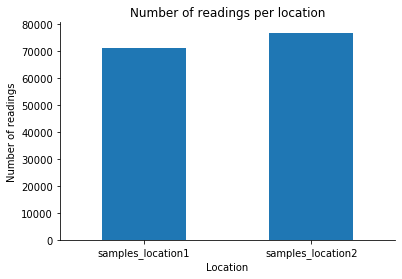

In [6]:
df_samples.groupby('location_id') \
    .size() \
    .plot \
    .bar(rot=0)

plt.ylabel('Number of readings')
plt.xlabel('Location')
plt.title('Number of readings per location')
sns.despine()

### Number of Unique EPC Codes per Location

Location 2 has significantly more unique EPC codes indicating that it is noisier.

In [7]:
df_samples.groupby('location_id').epc.nunique()

location_id
samples_location1    320
samples_location2    792
Name: epc, dtype: int64

### Distribution of Inside vs. Outside Readings Across Labelsets

The relative number of readings of RFID-tags inside/outside a box is similar for labelset 1/2. Labelset 3 has significantly more RFID tags outside of the box.

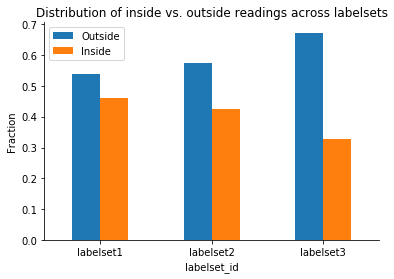

In [8]:
df_samples.groupby('labelset_id') \
    .in_box \
    .value_counts(normalize=True) \
    .unstack() \
    .rename(columns={0: 'Outside', 1: 'Inside'}) \
    .plot \
    .bar(rot=0)

plt.ylabel('Fraction')
plt.title('Distribution of inside vs. outside readings across labelsets')
plt.legend()
sns.despine()

### Distribution of Inside vs. Outside Readings Across Locations

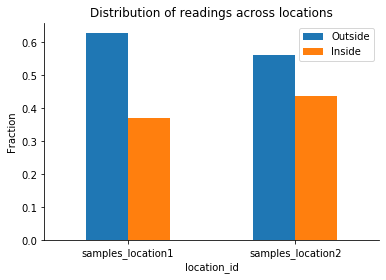

In [9]:
df_samples.groupby('location_id') \
    .in_box \
    .value_counts(normalize=True) \
    .unstack() \
    .rename(columns={0: 'Outside', 1: 'Inside'}) \
    .plot \
    .bar(rot=0)

plt.ylabel('Fraction')
plt.title('Distribution of readings across locations')
plt.legend()
sns.despine()

### Number of Unique EPC Codes

In [10]:
df_samples.epc.nunique()

1082

### Distribution of Number of Readings per EPC Code

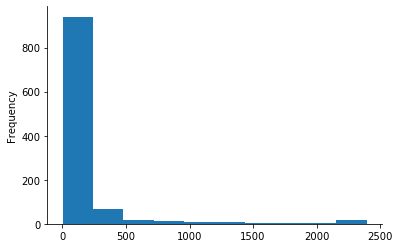

In [11]:
df_samples.groupby('epc')['epc'].count().plot.hist()
sns.despine()

## Train/Test Split

We split the data into train/test by `location_id`.

In [12]:
df_train = df_samples[df_samples.location_id == 'samples_location1'].copy()
df_test = df_samples[df_samples.location_id == 'samples_location2'].copy()

print('Samples train: {}'.format(len(df_train)))
print('Samples test: {}'.format(len(df_test)))

Samples train: 71271
Samples test: 76783


In [13]:
df_train.head(2)

,beam_id,epc,frequency,in_box,labelset_id,location_id,phase,rssi,sample_id,time
0,0,30347A12301D8FC59682FEFA,866900000,0,labelset3,samples_location1,15,-649,sample4,1.572351e+09
1,0,30347A12301D87C59682FF25,866900000,0,labelset3,samples_location1,55,-687,sample4,1.572351e+09


In [14]:
df_test.head(2)

,beam_id,epc,frequency,in_box,labelset_id,location_id,phase,rssi,sample_id,time
0,0,E28011700000020D350CABCF,866900000,1,labelset3,samples_location2,18,-687,sample4,1.572351e+09
1,0,E28011700000020D350CE1BE,866900000,1,labelset3,samples_location2,29,-609,sample4,1.572351e+09


## Feature Engineering

### Extract Features

In [15]:
def q80(x):
    return pd.Series.quantile(x, q=0.8)

def q20(x):
    return pd.Series.quantile(x, q=0.2)

def extract_features(df):
    agg = df.groupby('epc').agg(
        max_rssi=('rssi','max'),
        min_rssi=('rssi','min'),
        number_observations=('rssi','count'),
        median_rssi=('rssi', 'median'),
        quantile80_rssi=('rssi', q80),
        quantile20_rssi=('rssi', q20),
    )
    
    return agg

In [16]:
extract_features(df_train)

,max_rssi,min_rssi,number_observations,median_rssi,quantile80_rssi,quantile20_rssi
epc,,,,,,
30347A12301D51459682FF61,-649,-814,143,-729.0,-701.0,-754.0
30347A12301D52459682FF65,-620,-795,366,-701.0,-680.0,-729.0
30347A12301D52859682FF78,-598,-830,1145,-680.0,-641.0,-719.0
30347A12301D52C59682FF77,-747,-747,1,-747.0,-747.0,-747.0
30347A12301D53059682FF76,-687,-719,4,-701.0,-695.4,-708.2
...,...,...,...,...,...,...
E2806894000050020364F08D,-358,-779,981,-478.0,-440.0,-538.0
E2806894000050020364FC8D,-313,-719,939,-506.0,-469.0,-566.0
E2806894000050020365048D,-308,-807,983,-488.0,-446.0,-548.0


In [17]:
df_train_features = extract_features(df_train)

X_train = df_train_features.values
y_train = df_train_features.index.isin(clean_epcs).astype(int)

df_test_features = extract_features(df_test)

X_test = df_test_features.values
y_test = df_test_features.index.isin(clean_epcs).astype(int)

CLASS_NAMES = np.array(['Outside', 'Inside'])

### Visualize `max(RSSI)` vs. `min(RSSI)`

We can see that a simple classifier with two features should already do reasonably well. 

In [18]:
c1 = df_train_features.iloc[np.where(y_train == 0)]
c2 = df_train_features.iloc[np.where(y_train == 1)]

Text(0, 0.5, 'min_rssi')

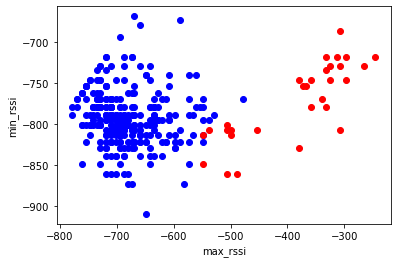

In [19]:
plt.scatter(c1['max_rssi'], c1['min_rssi'], c='b')
plt.scatter(c2['max_rssi'], c2['min_rssi'], c='r')
plt.xlabel('max_rssi')
plt.ylabel('min_rssi')

### Scaling

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

## Modeling + Classification

### Most-frequent Baseline

In [21]:
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

              precision    recall  f1-score   support

     Outside     0.9621    1.0000    0.9807       762
      Inside     0.0000    0.0000    0.0000        30

    accuracy                         0.9621       792
   macro avg     0.4811    0.5000    0.4903       792
weighted avg     0.9257    0.9621    0.9435       792



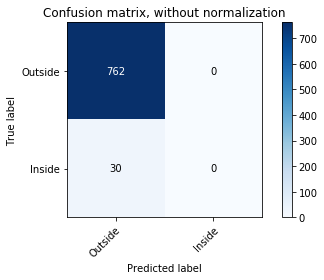

In [22]:
evaluate(y_test, y_pred_test, class_names=CLASS_NAMES)

### Logistic Regression

In [23]:
clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

              precision    recall  f1-score   support

     Outside     0.9870    1.0000    0.9935       762
      Inside     1.0000    0.6667    0.8000        30

    accuracy                         0.9874       792
   macro avg     0.9935    0.8333    0.8967       792
weighted avg     0.9875    0.9874    0.9862       792



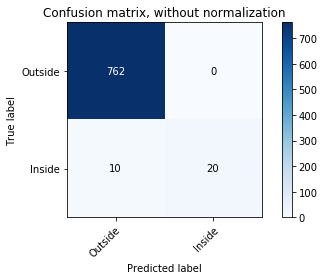

In [24]:
evaluate(y_test, y_pred_test, class_names=CLASS_NAMES)

### Inspect Feature Importance

In [25]:
eli5.show_weights(clf, feature_names=df_train_features.columns.values, target_names=CLASS_NAMES)

Weight?,Feature
+2.652,max_rssi
+2.286,quantile80_rssi
+1.905,median_rssi
+1.376,number_observations
+1.320,quantile20_rssi
-0.684,min_rssi
-5.203,<BIAS>
